# Training a classifier

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import os 
import pickle 
import time
from utils.utils import *

%matplotlib inline

In [2]:
def display_image(img):
    '''Auxiliar function to plot cv2 images into jupyter notebook'''
    return convert_color(img,'BGR2RGB')

## Load data paths

Loading the file generated by __Split_data.ipynb__ containing the path to both training and testing samples.

In [3]:
cars, notcars = pickle.load( open( "data_path.p", "rb" ) )

## Parameters

In [4]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

## Visualizing color features

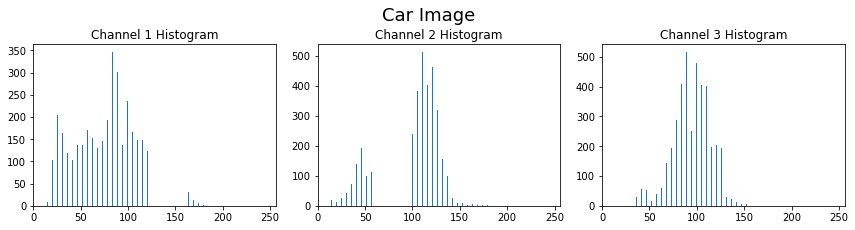

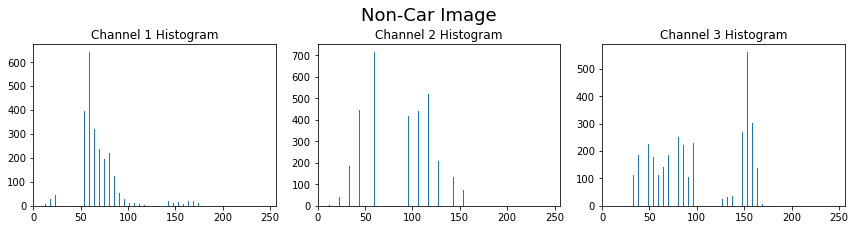

In [10]:
# Define a function to compute color histogram features  
def color_features(img, nbins=32):
    # Compute the histogram of the RGB channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    
    # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features
    
car_sample = cars['train'][10]
notcar_sample = notcars['train'][201]

car_image = cv2.imread(car_sample)
car_image = convert_color(car_image, conv='BGR2'+ color_space)

notcar_image = cv2.imread(notcar_sample)
notcar_image = convert_color(notcar_image, conv='BGR2'+ color_space)

ch1, ch2, ch3, bincen, feature_vec = color_features(car_image, nbins=32)

# Plot a figure with all three bar charts
fig = plt.figure(figsize=(12,3))
plt.suptitle('Car Image', y=1.05, fontsize=18)
plt.subplot(131)
plt.bar(bincen, ch1[0])
plt.xlim(0, 256)
plt.title('Channel 1 Histogram')
plt.subplot(132)
plt.bar(bincen, ch2[0])
plt.xlim(0, 256)
plt.title('Channel 2 Histogram')
plt.subplot(133)
plt.bar(bincen, ch3[0])
plt.xlim(0, 256)
plt.title('Channel 3 Histogram')
fig.tight_layout()

ch1, ch2, ch3, bincen, feature_vec = color_features(notcar_image, nbins=32)

# Plot a figure with all three bar charts
fig = plt.figure(figsize=(12,3))
plt.suptitle('Non-Car Image', y=1.05, fontsize=18)
plt.subplot(131)
plt.bar(bincen, ch1[0])
plt.xlim(0, 256)
plt.title('Channel 1 Histogram')
plt.subplot(132)
plt.bar(bincen, ch2[0])
plt.xlim(0, 256)
plt.title('Channel 2 Histogram')
plt.subplot(133)
plt.bar(bincen, ch3[0])
plt.xlim(0, 256)
plt.title('Channel 3 Histogram')
fig.tight_layout()

## Visualizing HOG features

/home/camilog/anaconda3/envs/Neptuno/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


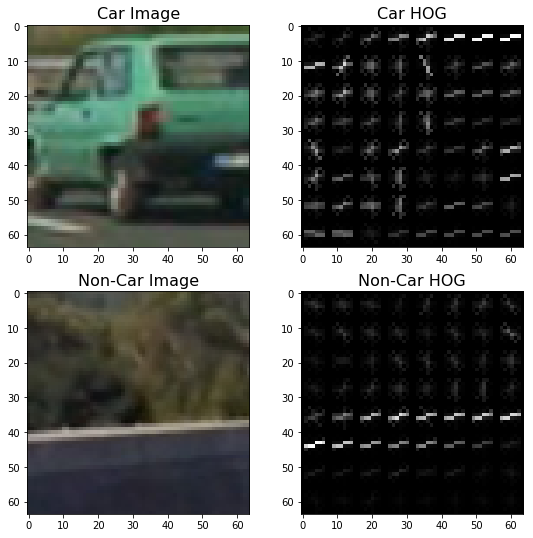

In [10]:
car_sample = cars['train'][10]
notcar_sample = notcars['train'][201]

car_image = cv2.imread(car_sample)
_, hog_car = get_hog_features(car_image[:,:,0], 9, 8, 2, vis=True, feature_vec=True)

notcar_image = cv2.imread(notcar_sample)
_, hog_notcar = get_hog_features(notcar_image[:,:,0], 9, 8, 2, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9,9))
#f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(display_image(car_image))
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(hog_car, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(display_image(notcar_image))
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(hog_notcar, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

## Extract features for training and test

In [12]:
sample_size = 500

# Get training data
car_samples = cars['train']
notcar_samples = notcars['train']
car_features = extract_features(car_samples, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcar_samples, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X_train = np.vstack((car_features, notcar_features)).astype(np.float64)     
# Define the labels vector
y_train = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Get testing data
car_samples = cars['test']
notcar_samples = notcars['test']
car_features = extract_features(car_samples, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcar_samples, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X_test = np.vstack((car_features, notcar_features)).astype(np.float64)     
# Define the labels vector
y_test = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


/home/camilog/anaconda3/envs/Neptuno/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


## Fit a per-column scaler

Scaling all the features so that none of them can outweight all the others.

In [13]:
temporal = np.concatenate([X_train, X_test])
X_scaler = StandardScaler().fit(temporal)
scaled_data = X_scaler.transform(temporal)
X_train=scaled_data[:y_train.shape[0]]
X_test=scaled_data[y_train.shape[0]:]

## Train a classifier

In [14]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1020
1.59 Seconds to train SVC...
Train Accuracy of SVC =  0.9999
Test Accuracy of SVC =  0.9839


## Using PCA for dimensionality reduction

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=500)
X_train_reduced = pca.fit_transform(X_train)

np.sum(pca.explained_variance_ratio_)

0.98671246667140144

In [16]:
print('Previous dimensionality of data = ', X_train.shape)
print('New dimensionality of data = ', X_train_reduced.shape)

Previous dimensionality of data =  (14211, 1020)
New dimensionality of data =  (14211, 500)


In [17]:
# Use a linear SVC 
svc2 = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc2.fit(X_train_reduced, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc2.score(X_train_reduced, y_train), 4))
print('Test Accuracy of SVC = ', round(svc2.score(pca.transform(X_test), y_test), 4))
# Check the prediction time for a single sample
t=time.time()

0.79 Seconds to train SVC...
Train Accuracy of SVC =  0.9996
Test Accuracy of SVC =  0.9842


## Tuning the classification model

In [18]:
from sklearn import grid_search
parameters = {'loss':('hinge', 'squared_hinge'), 'C':[0.1, 1, 10]}
svr = LinearSVC()
clf = grid_search.GridSearchCV(svr, parameters)
t=time.time()
clf.fit(X_train_reduced, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

print('Train Accuracy of SVC = ', round(clf.score(X_train_reduced, y_train), 4))
print('Test Accuracy of SVC = ', round(clf.score(pca.transform(X_test), y_test), 4))

/home/camilog/anaconda3/envs/Neptuno/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/camilog/anaconda3/envs/Neptuno/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


12.5 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9845


In [19]:
print("These are the best parameters found using grid search:", clf.best_params_)

These are the best parameters found using grid search: {'loss': 'hinge', 'C': 0.1}


## Saving classifier, scaler and PCA

In [26]:
pickle.dump([clf, X_scaler, pca], open( "trained_classifier.p", "wb"))